<a href="https://colab.research.google.com/github/isabellaimcc/Final-Data-Bootcamp-Project/blob/main/Isabella_M_Cheque_C_Modeling_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset
1. dowload the zip file
2. double click to obtain the .csv


In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.model_selection import GridSearchCV

In [147]:
df = pd.read_csv('gym_dataset.csv')
df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


In [148]:
#Here, I am renaming the columns that have extra words within parenthises, which is the same thing I did in my EDA notebook. This will make it easier for me to write code more concisely

df.rename(columns = {'Session_Duration (hours)': 'Session_Duration'},
          inplace = True)
df.rename(columns = {'Weight (kg)': 'Weight'},
          inplace = True)
df.rename(columns = {'Height (m)': 'Height'},
          inplace = True)
df.rename(columns = {'Water_Intake (liters)': 'Water_Intake'},
          inplace = True)
df.rename(columns = {'Workout_Frequency (days/week)': 'Workout_Frequency'},
          inplace = True)

To start off my modeling, I will create a linear regression model to predict the amount of calories burned based on the workout session duration.


In [149]:
#selecting the Session_Duration for X and Calories_Burned for the target (y)
X = df[['Session_Duration']]
y = df['Calories_Burned']

#splitting the data into training and testing sets. the test size will be 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22)

#creating and training the model
lr_duration = LinearRegression() #creating the model
lr_duration.fit(X_train, y_train) #fitting the model to the training data

#making predictions with the testing set
y_pred = lr_duration.predict(X_test) #predicted calories

#evaluating the performance of the linear regression model
mse = mean_squared_error(y_test, y_pred) #calculates the MSE
r2 = r2_score(y_test, y_pred) #calculates the R squared score, which represents the proportion of variance in calories burned that can be explained by session duration
print(f'Mean Squared Error: {mse: .2f}') #round to two decimal points for clarity
print(f'R-squared: {r2: .2f}') #rounded to two decimal points for clarity



Mean Squared Error:  11652.64
R-squared:  0.83


The R-squared seems okay, but the MSE seems quite large.

In [150]:
coef = lr_duration.coef_[0] #this will represent the slope --> calories burned per hour
intercept = lr_duration.intercept_ #finds the base amount of calories burned when the duration of workout equals 0 hours
print(f'Calories Burned = {intercept:.2f} + {coef: .2f}*Session_Duration')

Calories Burned = 2.50 +  719.41*Session_Duration


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


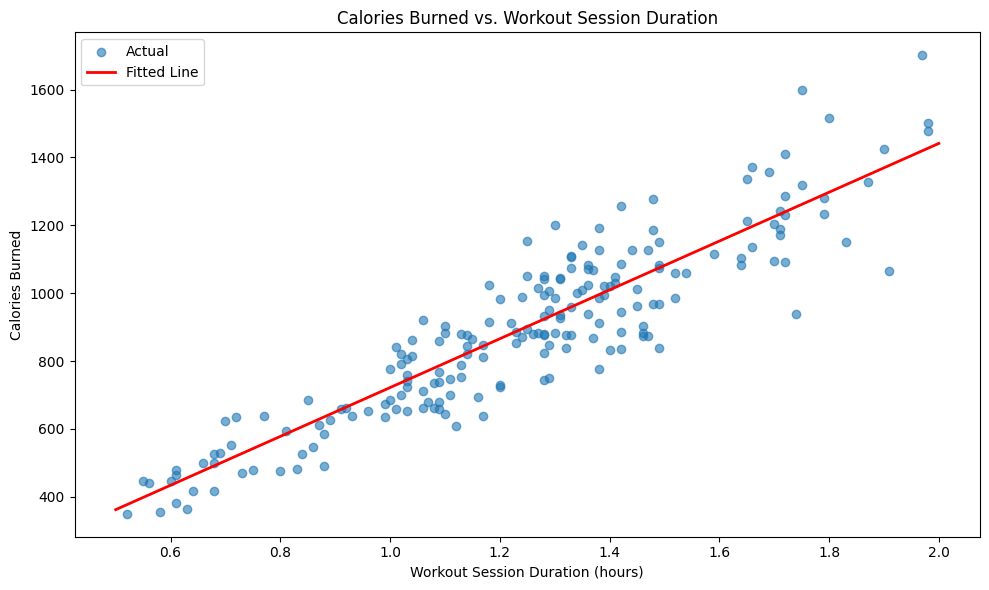

In [151]:
plt.figure(figsize=(10, 6))
plt.scatter(
    X_test, y_test, alpha = 0.6, label = 'Actual' #using the actual test points
)

x_line = np.linspace(X['Session_Duration'].min(), X['Session_Duration'].max(), 100) #generating 100 points between the min amd max Session_Duration
y_line = lr_duration.predict(x_line.reshape(-1, 1)) #predicting the calories burned for Session_Duration values generated in x_line
plt.plot(x_line, y_line, color = 'red', lw = 2, label = 'Fitted Line') #plotting the fitted line using x_line and y_line. Setting the line with a red color and a width of 2

plt.title('Calories Burned vs. Workout Session Duration')
plt.xlabel('Workout Session Duration (hours)')
plt.ylabel('Calories Burned')
plt.legend()
plt.tight_layout()
plt.show()

By looking at the linear regression model's graph, I see that the clusters of points are around the fitted prediction line, which makes sense because the R-squared value  came out to be 0.83. So, the workout session duration (in hours) is a good predictor of the amount of calories burned in a workout session.

By refering back to this calculation:

* Calories Burned = 2.50 +  719.41*Session_Duration

I know that for each extra hour of exercise, 719.41 calories will be burned.

However, there is still 17% of variance that is not explained by workout duration. I will now add another independent variable: Avg_BPM, which represents the average heart rate during workout sessions.

In [152]:
X = df[['Session_Duration', 'Avg_BPM']] #selecting the two predictors
y = df['Calories_Burned'] #indicating the target variable

In [153]:
#splitting the dta into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 24
)

In [154]:
#scaling the features so that the duration of workout and heartreat bpm are on a similar scale
scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [155]:
#fitting the mutlivariate linear regression model
model = LinearRegression()
model.fit(X_trained_scaled, y_train)

#predicting using the testing set
y_pred = model.predict(X_test_scaled)

In [156]:
#evaluating the performance of the multivariate linear regression model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Multivariate Regression MSE: {mse: .2f}')
print(f'Multivariate Regression R-squared: {r2: .2f}')

Multivariate Regression MSE:  5453.54
Multivariate Regression R-squared:  0.93


I already notice that the R-Squared is higher with the additional predictor Avg_BPM. Also, the MSE drastically decreased with the additional predictor. Therefore, the mutlivariate linear regression model is better than the univariate model.

#Now, I'll move on to creating a decision tree model

In [157]:
numeric_features = [ #indicating the numeric features
    'Age', 'Weight', 'Height', 'Max_BPM',
    'Avg_BPM', 'Resting_BPM', 'Session_Duration',
    'Fat_Percentage', 'Water_Intake', 'Workout_Frequency',
    'Experience_Level', 'BMI'
]
categorical_features = ['Gender', 'Workout_Type'] #indicating the categorical features

In [158]:
#separating the predictors (X) from the target to be predicted (y)

X = df[numeric_features + categorical_features]
y = df['Calories_Burned']

In [159]:
#splitting the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 24
)

In [160]:
#creating a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_features), #applying StandardScaler to the numerical features
        ('cat', OneHotEncoder(drop = 'first', sparse_output = False), categorical_features)] #applying OneHotEncoder to the categorical features, which converts them into a numerical representation
)

In [161]:
# building a Pipeline
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor), #preprocess the data
    ('regressor', DecisionTreeRegressor(random_state = 24)) #DecisionTreeRegressor model added to the pipeline to make predictions.
])

In [162]:
pipeline.fit(X_train, y_train) #training the pipeline on the training data

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Weight', 'Height',
                                                   'Max_BPM', 'Avg_BPM',
                                                   'Resting_BPM',
                                                   'Session_Duration',
                                                   'Fat_Percentage',
                                                   'Water_Intake',
                                                   'Workout_Frequency',
                                                   'Experience_Level', 'BMI']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'Workout_Type'])])),
                ('regressor', DecisionTreeRegressor(random_state=24))])

In [163]:
y_pred = pipeline.predict(X_test) #making predictions using the testing set

In [164]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Decision Tree MSE: {mse: .2f}') #round to two decimal points for clarity
print(f'Decision Tree R-squared: {r2: .2f}')

Decision Tree MSE:  5607.86
Decision Tree R-squared:  0.93


Here, I notice that, for the decision tree, the MSE is higher while the R-squared is the same as those for the multivariate linear regression model. The decision tree is still explaining the same proportion of variance (the same R-squared value). However, the MSE for the decision tree is higher because there could've been large errors from the piecewise-constant predictions in the decision tree. These errors could have driven up MSE.

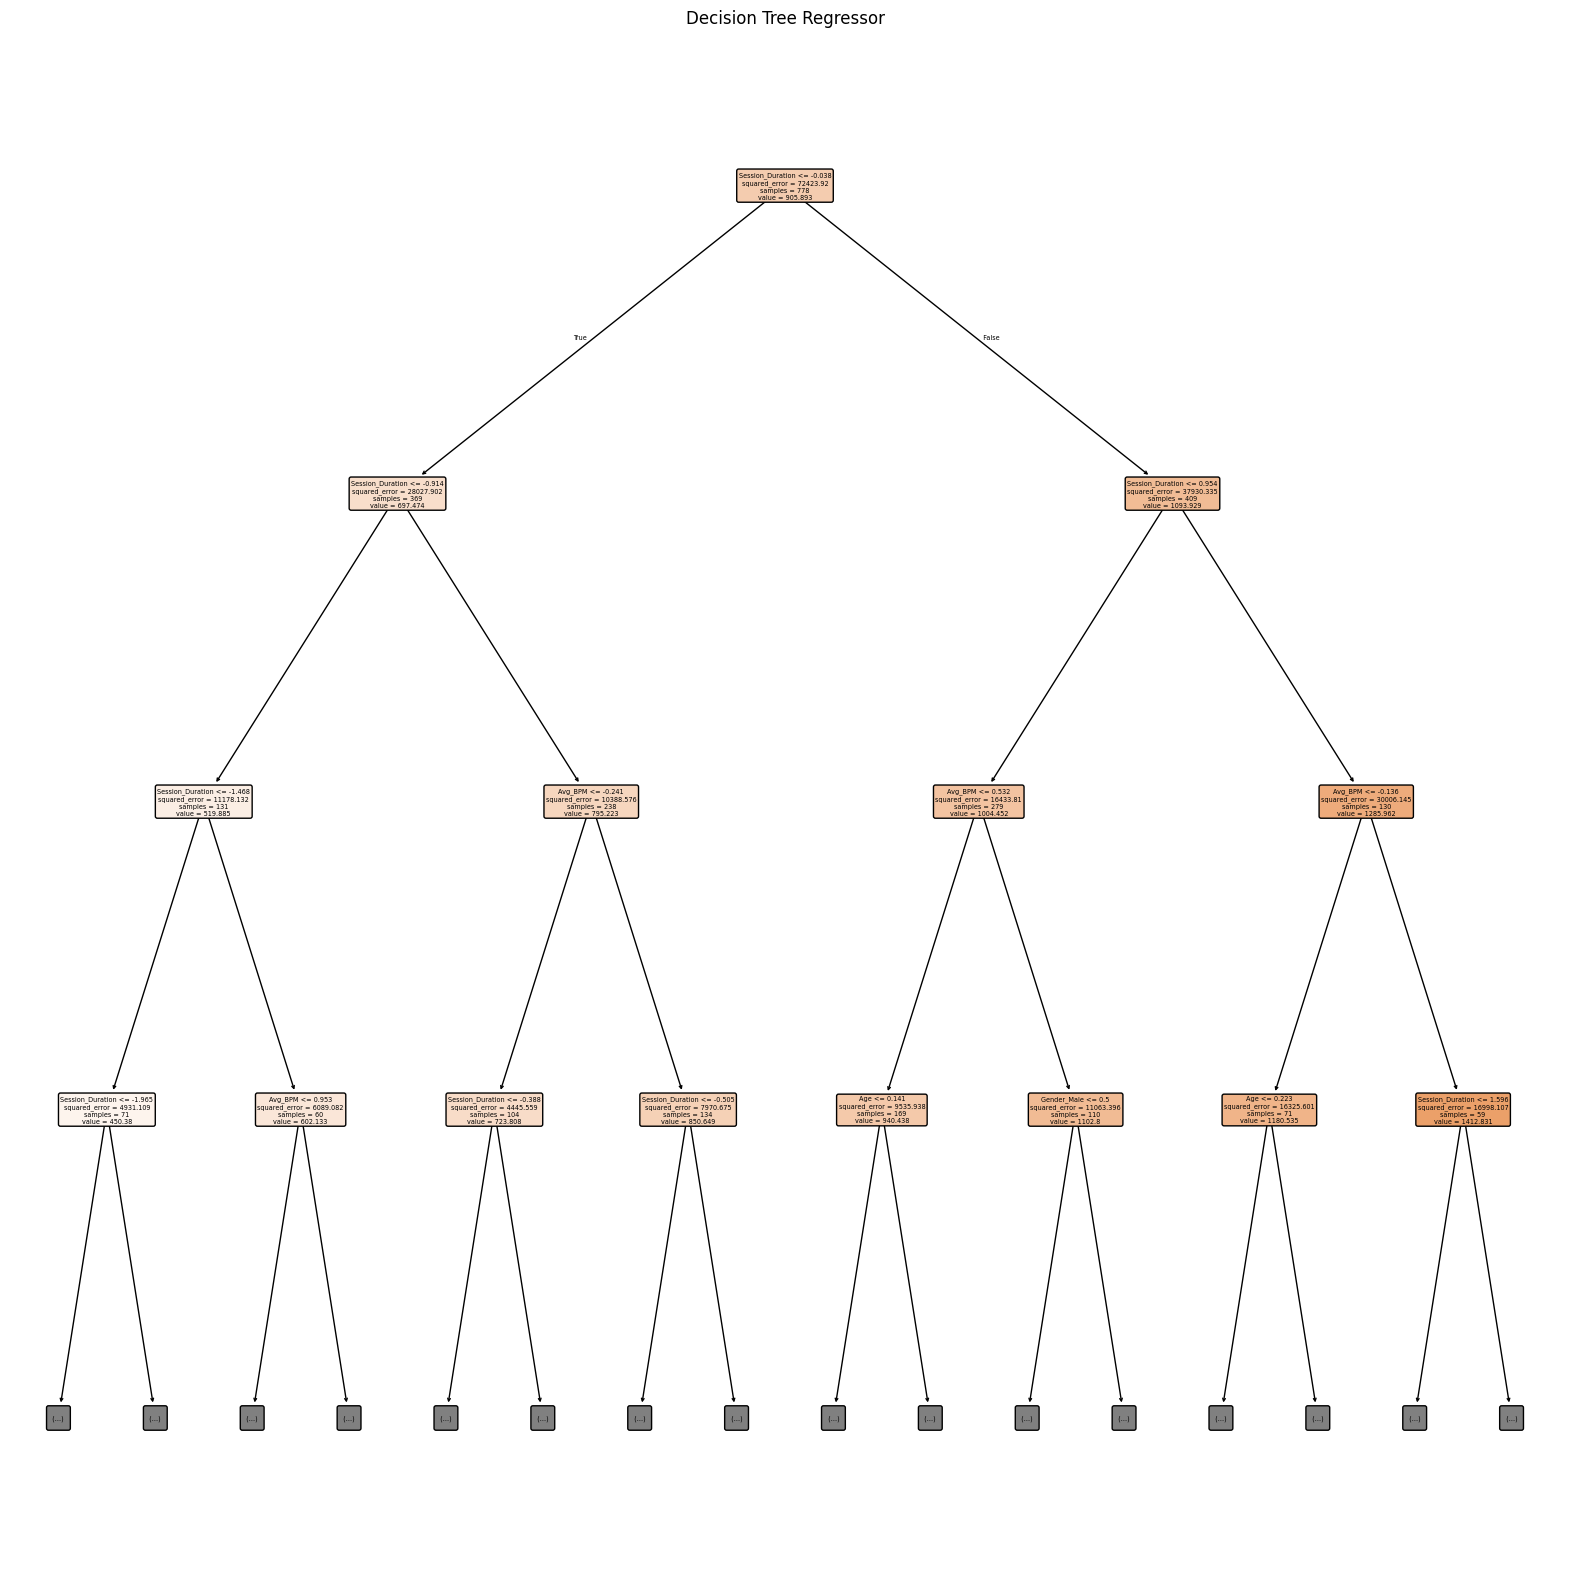

In [165]:
#the following code visualizes the decision tree
regressor = pipeline.named_steps['regressor'] #extracting the DecisionTreeRegressor from the pipeline

preprocessor = pipeline.named_steps['preprocessor']
preprocessor.fit(X_train) #fitting the preprocessor to the training data

num_features = numeric_features
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features) #this gets the names of the categorical features after transformation
all_features = list(numeric_features) + list(cat_features) #combining numerical and categorical features into a single list named all_features

plt.figure(figsize = (20, 20))
plot_tree(regressor, #regressor variable that holds the decision tree model
          feature_names = all_features, #instructing for the visualization to display the feature names
          filled = True, #shows colors that represent values
          rounded = True, #rounded roners for the decision tree boxes
          max_depth = 3) #limiting to 3 for clarity.
plt.title('Decision Tree Regressor')
plt.show()

#Now, I'll move on to create a Random Forest Regressor model.

In [166]:
#the numerical features and categoric features were already specified above in the previous model


In [167]:
X = df[numeric_features + categorical_features] #the predictors
y = df['Calories_Burned'] #what I want to predict

In [168]:
#splitting the data into training and testing (20%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

In [169]:
#building a ColumnTransformer to preprocess the columns
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_features), #scaling the numeric values
        ('cat', OneHotEncoder(drop = 'first', sparse_output = False), categorical_features) #onehot encoding the categorical values
    ])

In [170]:
#Creating a pipeline for preporcessing and then fitting to Random Forest
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators = 100, #setting the numbner of tress int he forest to 100
                                        random_state = 24))
])


In [171]:
#fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Weight', 'Height',
                                                   'Max_BPM', 'Avg_BPM',
                                                   'Resting_BPM',
                                                   'Session_Duration',
                                                   'Fat_Percentage',
                                                   'Water_Intake',
                                                   'Workout_Frequency',
                                                   'Experience_Level', 'BMI']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'Workout_Type'])])),
                ('regressor', RandomForestRegressor(random_state=24))])

In [172]:
#making predictions on the testing set by using the fitted pipeline
y_pred = pipeline.predict(X_test)

In [173]:
#calculating the MSE and R-squared values
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Random Forest MSE: {mse: .2f}')
print(f'Random Forest R-squared: {r2: .2f}')

Random Forest MSE:  2779.98
Random Forest R-squared:  0.97


Wow! By looking at the Random Forest MSE and R-squared, I see that the MSE is significantly lower than any of the previous models. I also notice that the R-squared is higher than any other model too. Therefore, the Random Forest Model is the best model!

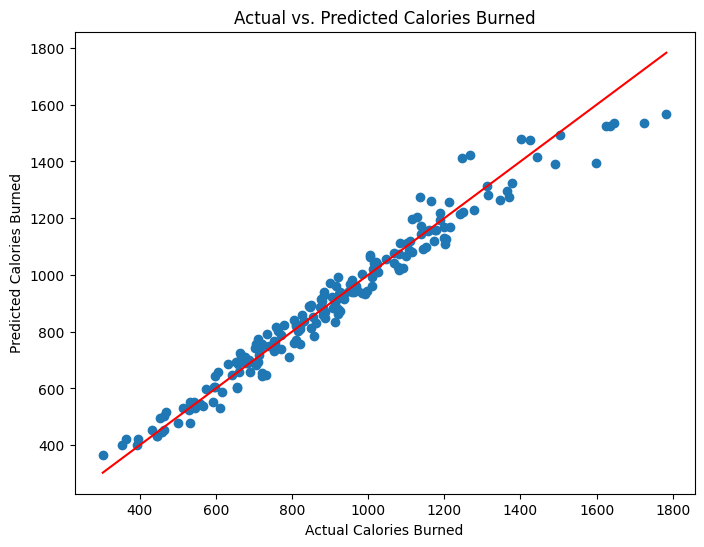

In [174]:
#creating a grpah to visualize the actual vs predicted scatter of the random forest model
plt.figure(figsize = (8, 6))
plt.scatter(y_test, y_pred) #specifying to use the scatter of actual in x-axis and then the predicted in the y-axis

#creating a 45 degree line that represents a perfect prediction
min_val = min(min(y_test), min(y_pred)) #minimum value for actual and predicted
max_val = max(max(y_test), max(y_pred)) #maximum value for actual and predicted
plt.plot([min_val, max_val], [min_val, max_val], color = 'red') #plotting the 45 degree line

#adding descriptive title and labelsp
plt.title('Actual vs. Predicted Calories Burned')
plt.xlabel('Actual Calories Burned')
plt.ylabel('Predicted Calories Burned')
plt.show()


I see that there is a tight clusturing around the 45 degree line, which corroborates the high R-squared value of 0.97. Since the points are very close the 45 degree line, I conlcude that the random forest model makes accurate predictions.